# Importing Required Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Functions

In [2]:
def num_unique_values_in_cols(df,cols = None):
    if cols != None:
        if type(cols) == str:
            cols = [cols]
        d_unique = {}
        for col in cols:
            d_unique[col] = df[col].value_counts().count()
    return d_unique
            

# Common Fuctions Across Algorithms

In [1]:
def remove_outliers(df_in,outlier_cols):
    df = df_in.copy()
    if type(outlier_cols) == str:
        outlier_cols = [outlier_cols]
    
    desc = df.describe()
    for col in outlier_cols:
        q1 = desc.loc['25%',col]
        q3 = desc.loc['75%',col]
        iqr = q3 - q1
        low = q1 - (1.5 * iqr)
        high = q3 + (1.5 * iqr)
        df = df[(df[col] >= low) & (df[col] <= high)]
        
    return df

In [3]:
def convert_cat(df, cat_cols,output_col=None):
    """
    This function converts all categorical columns into numerical boolean columns.
    
    There are 3 parameters: df, cat_cols, and output_var. 
    
    1. df is the dataframe which needs to have categorical variables converted to numerical variables
    2. cat_cols needs to be a list that contains the names of all categorical columns that need to be converted.
    3. output_var is the name of the output or response variable.  It is set to 'Output' as default."""
    
    df.reset_index(inplace = True, drop = True)
    df_out = df.copy()
    
    for col in cat_cols:
        dummy_col = pd.get_dummies(df_out[col],drop_first = True)
        df_out.drop(col,axis=1, inplace = True)
        df_out = df_out.join(dummy_col)
    
    if output_col != None:
        loc_df_out = list(df_out.columns).index(output_col)
        df_out = df_out[list(df_out.columns[:loc_df_out]) + list(df_out.columns[loc_df_out + 1:]) + list(df_out.columns[loc_df_out:loc_df_out + 1])]
    return df_out

In [2]:
def normalize(df,cols_to_ignore = None):
    """
    This function takes in a dataframe as a parameter and returns the same dataframe with all the features normalized between 0 and 1 using rescaling (min-max normalization)
    """
    l_min = []
    l_max = []
    desc = df.describe()
    if cols_to_ignore == None:
        for col in df.columns:
            l_min.append(desc[col]['min'])
            l_max.append(desc[col]['max'])
        
        t_min = list(zip(df.columns, l_min))
        t_max = list(zip(df.columns, l_max))
 

    else:
        for col in df.drop(cols_to_ignore,axis = 1).columns:
            l_min.append(desc[col]['min'])
            l_max.append(desc[col]['max'])

        t_min = list(zip(df.drop(cols_to_ignore,axis = 1).columns, l_min))
        t_max = list(zip(df.drop(cols_to_ignore,axis = 1).columns, l_max))
    
   
    d_min = {}
    for col,val in t_min:
        d_min[col]=val
    
    d_max = {}
    for col,val in t_max:
        d_max[col]=val
    
    df_copy = df.copy()
    for key in d_min.keys():
        df_copy[key] = df_copy[key].apply(lambda x: (x - d_min[key])/ (d_max[key] - d_min[key]))
    
    return df_copy

In [5]:
def split_df(df,test_size = 0.3,df_to_return = 'df_train'):
    """
    This function takes in a Pandas DataFrame and returns a 
    dataframe that is a subset of that Pandas DataFrame.
    
    There are 3 parameters: df, test_size, and df_to_return
    
    df needs to be a Pandas DataFrame and is the superset dataframe to be divided.
    test_size is the proportion of the dataframe you want to be the testing dataset.
    test_size is set to 0.3 by default.
    df_to_return needs to specified as either 'df_train' or df_test' 
    to return the correct subset dataframe. df_to_return is set to 'df_train' by default
    """
    split_num = int(df.count()[0] * (1-test_size) //1)
    df_train = df.iloc[:split_num,:]
    df_test = df.iloc[split_num:,:]
    if df_to_return in ['df_train','train']:
        return df_train
    elif df_to_return in ['df_test','test']:
        return df_test

In [ ]:
def shuffled_split_dfs(df,test_size = 0.3):
    """
    This function takes in a Pandas DataFrame and returns a list of 2
    dataframes.  The first dataframe is the train and the second is the test df.
    
    There are 2 parameters: df and test_size
    
    df needs to be a Pandas DataFrame and is the superset dataframe to be divided.
    test_size is the proportion of the dataframe you want to be the testing dataset.
    test_size is set to 0.3 by default.
    """
    df_copy = df.copy()
    df_copy = df_copy.sample(frac = 1).reset_index(drop = True)
    split_num = int(df_copy.count()[0] * (1-test_size) //1)
    df_train = df_copy.iloc[:split_num,:]
    df_test = df_copy.iloc[split_num:,:]
    return ([df_train,df_test])

In [3]:
def check_accuracy(df = None,pred_df = None, test_df = None, algo = 'lin',target_class = None):
    import numpy as np
    """
    This function takes in a pandas DataFrame and returns the accuracy of the model
    
    There are 2 parameters: df and algo
    
    1. df needs to be a Pandas DataFrame and algo is the algorithm used.
    2. algo is set to 'lin' by default but can also be specified as 'log'"""
    
    if algo == 'lin':
        df_out = df.copy()
        df_out['error'] = df.iloc[:,-2] - df.iloc[:,-1]
        ME = df_out['error'].mean()
        MAE = np.abs(df_out['error']).mean()
        RMSE = (sum(df_out['error']**2)/df_out.count()[0]+1) ** 0.5
        
        
        return {'ME':ME,'MAE':MAE,'RMSE':RMSE}
    
    elif algo == 'log':
        return sum(df['Correct?']/df.count()[0])
    
    elif algo == 'knn':
        pred = pred_df[target_class]
        test = test_df[target_class]
        return sum(pred == test) / len(pred)

# Linear Regression and Logistic Regression

In [7]:
def stoch_grad_desc(dataset,output_col,cols_to_ignore = None,alpha = 0.3,epoch = 10,algo = 'lin',initial_coeffs = 1):
    """
    This function returns a list of the coefficients for the specified algorithm.  
    Currently, this function only performs Linear and Logistic Regression.
    
    The 4 parameters are: dataset, alpha, epoch, and algo
    
    1. dataset needs to be a pandas DataFrame
    2. alpha is the alpha value used in stochiastic gradient descent.  It is set at 0.3 by default.
    3. epoch is the number of iterations through each row in the dataset algorithm will perform.  epoch is set to 10 by default.
    4. algo is the specific algorithm to be used.  algo is 'lin' by default for Linear Regression but can also be specified as 'log' for Logistic Regression
    """

    loc_output_col = list(dataset.columns).index(output_col)
    dataset = dataset[list(dataset.columns[:loc_output_col]) + list(dataset.columns[loc_output_col+1:]) + list(dataset.columns[loc_output_col:loc_output_col + 1])]
    
    from math import exp
    count_rows = dataset.count()[1]
    
    if cols_to_ignore != None:
        dataset_1 = pd.DataFrame(pd.Series(np.ones(dataset.count()[0])),columns = ['X0']).join(dataset.drop(cols_to_ignore,axis = 1))
    else:
        dataset_1 = pd.DataFrame(pd.Series(np.ones(dataset.count()[0])),columns = ['X0']).join(dataset)
        
    coeffs = list(np.ones(len(dataset_1.columns[0:-1])))
    coeffs = [i * initial_coeffs for i in coeffs]
    
    df_columns = list(dataset_1.columns)
    df_input_cols = df_columns
    df_input_cols.remove(output_col)
    
    for ep in range(epoch):
        for row in range(count_rows):
            y = dataset_1.loc[row,output_col]
            output_terms = []
            #return y
            for col in df_input_cols:
                output_terms.append((coeffs[dataset_1.columns.get_loc(col)],dataset_1.loc[row,col]))
            
            output_list = [(x*y) for (x,y) in output_terms]
            
            output = sum(output_list)
            
            if algo == 'lin':
                pred = output
                for i in range(len(coeffs)):
                    coeffs[int(i)] += alpha * (dataset_1.loc[row,output_col] - pred) * dataset_1.iloc[row,int(i)]
                
            elif algo == 'log':
                pred = 1 / (1 + exp(-output))
                
                for i in range(len(coeffs)):
                    coeffs[i] = coeffs[i] + alpha * (y - pred) * pred * (1 - pred) * dataset_1.iloc[row,i]
                    
    
    
    return coeffs

In [8]:
def make_predictions(dataset, coeff_list, output_col,cols_to_ignore = None,algo = 'lin'):
    """
    This function takes in a pandas DataFrame and a list that contains 
    coefficients for the specified algorith used in the stoch_grad_desc function
    and returns the same dataset (with the addition of the first column being 1s to
    represent X0 in the regression formula) plus a new column at the end, 'Prediction'.
    
    There are 3 parameters: dataset, coeff_list, and algo
    
    1. dataset is the dataframe to used to make predictions dataset needs to be a Pandas DataFrame
    2. coeff_list should be the list that was the result of running the stoch_grad_desc function
    3. algo is the specific algorithm to be used.  algo is set to 'lin' by default but can be set to 'log'"""
    
    loc_output_col = list(dataset.columns).index(output_col)
    dataset = dataset[list(dataset.columns[:loc_output_col]) + list(dataset.columns[loc_output_col+1:]) + list(dataset.columns[loc_output_col:loc_output_col + 1])]
    dataset_index = dataset.index
    
    if type(cols_to_ignore) == list and cols_to_ignore != None:
        df_ignored_cols = dataset.loc[:,cols_to_ignore]
    elif type(cols_to_ignore) != list and cols_to_ignore != None:
        df_ignored_cols = dataset.loc[:,[cols_to_ignore]]
    if cols_to_ignore != None:
        df_ignored_cols.reset_index(inplace = True)
    
    from math import exp
    
    dataset.reset_index(inplace = True, drop = True)
    
    if cols_to_ignore != None:
        dataset_out = pd.DataFrame(pd.Series(np.ones(dataset.count()[0]))).join(dataset.drop(cols_to_ignore,axis = 1))
    else:
        dataset_out = pd.DataFrame(pd.Series(np.ones(dataset.count()[0]))).join(dataset)

    
    dataset_out.rename(mapper = {0:'X0'},axis = 1, inplace = True)
    
    coeffs = coeff_list
    pred = []
    
    for row in range(dataset_out.count()[0]):
        output_terms = []
        for col in dataset_out.columns[0:-1]:
            output_terms.append((coeffs[dataset_out.columns.get_loc(col)],dataset_out.loc[row,col]))
        output_list = [x*y for (x,y) in output_terms]
        
        output = sum(output_list)
        if algo == 'lin':
            pred.append(output)
        
        elif algo == 'log':
            pred.append(1/(1 + exp(-output)))
    dataset_out = dataset_out.join(pd.DataFrame(pred))
    dataset_out.rename(mapper = {0: 'Prediction'},axis = 1, inplace = True)
    
    if algo == 'log':
        dataset_out['Crisp'] = dataset_out['Prediction'].apply(lambda predi: 1 if predi >= 0.5 else 0)
        dataset_out['Correct?'] = dataset_out.iloc[:,-3] == dataset_out['Crisp']
    
    if cols_to_ignore != None:
        dataset_out = pd.concat([df_ignored_cols,dataset_out],axis = 1)
    dataset_out.drop('X0',axis = 1,inplace = True)
    
    dataset_out.set_index(dataset_index,inplace = True)
    return dataset_out

# K Nearest Neighbors

In [185]:
def knn_1pt(df,new_point,output_col,k = 3):
    import statistics
    df1 = df.copy()
    new_pt_df = pd.DataFrame(data = [new_point + ['DK']],columns=df.columns)
    df_out = df1.append(new_pt_df,ignore_index = True)
    
    df2 = df_out.drop(output_col,axis=1)
    count_rows = df2.count()[0]
    new_pt_ind = count_rows - 1
    df2['sum_sqrd_diffs'] = 0
    for row_num in range(0,count_rows):
        sum_sqrd_diffs = 0
        for col_num in range(0,len(df2.columns)):
            sum_sqrd_diffs += (df2.iloc[new_pt_ind,col_num] - df2.iloc[row_num,col_num])**2
        df_out.loc[row_num,'sum_sqrd_diffs'] = sum_sqrd_diffs 
       
    df_out.loc[new_pt_ind,output_col] = statistics.mode(df_out.iloc[:new_pt_ind,:].sort_values('sum_sqrd_diffs').head(k)[output_col])
    #return df_out.sort_values('sum_sqrd_diffs').head(10)
    return df_out
              
    

In [4]:
def knn(df_train,new_pts_list,dep_col,k = 7,only_pred_df = True):
    from time import time
    start_time = time()
    import statistics
    
    nrows_new_pts = new_pts_list.shape[0]
    loc_dep_col = list(df_train.columns).index(dep_col)
    df_in = df_train[list(df_train.columns)[0:loc_dep_col] + list(df_train.columns)[loc_dep_col + 1:] + list(df_train.columns)[loc_dep_col:loc_dep_col + 1]] 
    
    if type(new_pts_list) == type(df_in):
        l_list_new_pts = []
        
        for rn in range(new_pts_list.count()[0]):
            l_list_new_pts.append(list(new_pts_list.iloc[rn,:]))
        new_pts_list = l_list_new_pts

    def knn_1pt(df,new_point,output_col = dep_col,k = k):
        
        df1 = df.copy()
        new_pt_df = pd.DataFrame(data = [new_point + ['DK']],columns=df1.columns)
        df_out = df1.append(new_pt_df,ignore_index = True)

        df2 = df_out.drop(output_col,axis=1)
        count_rows = df2.count()[0]
        new_pt_ind = count_rows - 1
        df2['sum_sqrd_diffs'] = 0
        for row_num in range(0,count_rows):
            sum_sqrd_diffs = 0
            for col_num in range(0,len(df2.columns)):
                sum_sqrd_diffs += (df2.iloc[new_pt_ind,col_num] - df2.iloc[row_num,col_num])**2
            df_out.loc[row_num,'sum_sqrd_diffs'] = sum_sqrd_diffs 
            
        
        if k == 1:
            df_out.loc[new_pt_ind,output_col] = statistics.mode(df_out.iloc[:new_pt_ind,:].sort_values('sum_sqrd_diffs').head(k)[output_col])
            df_in = df_out.drop('sum_sqrd_diffs',axis = 1).copy()
        else:
            try:
                mode = statistics.mode(df_out.sort_values('sum_sqrd_diffs')[0:k][output_col])
            except:
                closest = list(df_out.sort_values('sum_sqrd_diffs')[0:k][output_col].values)
                copy = closest[:]
                closest.sort(key = lambda x:copy.count(x))
                closest.reverse()
                mode = closest[0]
            df_out.loc[new_pt_ind,output_col] = mode
            df_in = df_out.drop('sum_sqrd_diffs',axis = 1).copy()
        return df_in
    

        
    
    for np in new_pts_list:
        df_in =  knn_1pt(new_point = np,df=df_in).copy()
    
    end_time = time()
    print("Program took %s seconds to run." % (end_time - start_time))
    if only_pred_df == True:
        return df_in[-nrows_new_pts:]
    return df_in

In [274]:
def knn_old(df_in,new_pts_list,dep_col,k = 7):
    import statistics
    
    if type(new_pts_list) == type(df_in):
        l_list_new_pts = []
        for rn in range(new_pts_list.count()[0]):
            l_list_new_pts.append(list(new_pts_list.iloc[rn,:]))
        new_pts_list = l_list_new_pts

    def knn_1pt(df,new_point,output_col = dep_col,k = k):
        
        df1 = df.copy()
        new_pt_df = pd.DataFrame(data = [new_point + ['DK']],columns=df.columns)
        df_out = df1.append(new_pt_df,ignore_index = True)

        df2 = df_out.drop(output_col,axis=1)
        count_rows = df2.count()[0]
        new_pt_ind = count_rows - 1
        df2['sum_sqrd_diffs'] = 0
        for row_num in range(0,count_rows):
            sum_sqrd_diffs = 0
            for col_num in range(0,len(df2.columns)):
                sum_sqrd_diffs += (df2.iloc[new_pt_ind,col_num] - df2.iloc[row_num,col_num])**2
            df_out.loc[row_num,'sum_sqrd_diffs'] = sum_sqrd_diffs 

        df_out.loc[new_pt_ind,output_col] = statistics.mode(df_out.iloc[:new_pt_ind,:].sort_values('sum_sqrd_diffs').head(k)[output_col])
        df_in = df_out.drop('sum_sqrd_diffs',axis = 1).copy()
        return df_in
    
    for np in new_pts_list:
        df_in =  knn_1pt(new_point = np,df=df_in).copy()
    return df_in

# K-Means Clustering

In [1017]:
def kmeans(df,k=3,epoch = 1):
    import random
    
    def euclid_squared_distance(pt1,pt2):
        return (pt1 - pt2)**2
    
    def select_k_points(dataframe = df,k = k):
        centroid_dataframe = pd.DataFrame(columns = dataframe.columns)
        centroid_indices = []
        for i in range(k):
            while True:
                rand_ind = random.choice(list(dataframe.index))
                if rand_ind not in centroid_indices:
                    centroid_indices.append(rand_ind)
                    break
            centroid_dataframe = centroid_dataframe.append(pd.DataFrame(data = [list(dataframe.loc[rand_ind,:])],columns = dataframe.columns,index = [rand_ind]))
            for row_num,ind in enumerate(list(centroid_dataframe.index)):
                centroid_dataframe.loc[ind,'Cluster'] = int(row_num)
        return centroid_dataframe
    
#     def kmeans_pp(dataframe = df,k = k):
#         centroid_dataframe = pd.DataFrame(columns = dataframe.columns)
#         centroid_indices = []
#         rand_ind = random.choice(list(dataframe.index))
#         centroid_indices.append(rand_ind)
#         centroid_dataframe.loc[rand_ind,:] = dataframe.iloc[rand_ind,:]
        
#         for i in range(k-1):
#             for row in dataframe.index:
#                 sqd_diffs_df = pd.DataFrame(columns = dataframe.columns)
#                 for cent_ind in centroid_indices:                
#                     sqd_diffs_df.loc[cent_ind,:] = (centroid_dataframe.loc[cent_ind,:] - dataframe.loc[row,:]) ** 2
#                     sqd_diffs_df['Sum_Squared_Diffs'] = sqd_diffs_df.sum(axis = 1)
#                 min_sqd_diffs = sqd_diffs_df['Sum_Squared_Diffs'].min()
#                 sqd_diffs_df=sqd_diffs_df[sqd_diffs_df['Sum_Squared_Diffs'] = 8]

            
    df['Cluster'] = np.nan
    
    centroid_df = select_k_points()

    centroid_indices = list(centroid_df.index)
    
    

    def one_iteration_k_means(dataframe = df,centroid_dataframe = centroid_df,cluster_col = 'Cluster'):
        for row in dataframe.index:
            sqd_diffs_df = pd.DataFrame(columns = centroid_dataframe.drop(cluster_col,axis = 1).columns)
            for cent_ind in centroid_indices:
                sqd_diffs_df.loc[cent_ind,:] = (centroid_dataframe.drop(cluster_col,axis = 1).loc[cent_ind,:] - dataframe.drop(cluster_col,axis = 1).loc[row,:]) ** 2 
            sqd_diffs_df['Sum_Sqd_Diffs'] = sqd_diffs_df.sum(axis = 1)
            for row_num,ind in enumerate(list(sqd_diffs_df.index)):
                sqd_diffs_df.loc[ind,'Cluster'] = int(row_num)

            smallest_ssd = sqd_diffs_df['Sum_Sqd_Diffs'].min()

            smallest_ssd_df = sqd_diffs_df[sqd_diffs_df['Sum_Sqd_Diffs'] == smallest_ssd]

            closest_centroid = pd.DataFrame(data = [smallest_ssd_df.loc[smallest_ssd_df.index[0],:].values],columns = list(sqd_diffs_df.columns),index = smallest_ssd_df.index)

            closest_centroid_ind = list(closest_centroid.index)[0]

            df.loc[row,cluster_col] = centroid_dataframe.loc[closest_centroid_ind,cluster_col]

            for row_cent in list(centroid_dataframe.index):
                
                if row_cent == closest_centroid_ind:
                    for col in list(centroid_dataframe.drop(cluster_col,axis = 1).columns):
                        centroid_dataframe.loc[row_cent,col] = (centroid_dataframe.loc[row_cent,col] + df.loc[row,col])/2
                        
        return centroid_dataframe
    
    for iteration in range(epoch):
        centroid_df = one_iteration_k_means() 

    return df

# Learning Vector Quantization

LVQ is an artificial neural network algorithm that allows you to choose how many training instances to hang onto and learns exactly
what those instances should look like.  LVQ is a classification algorithm.  Codebook vector contains all the input variables
and the output variable.

In [2]:
def euclid_dist(df,pt1,pt2,output_col):
    l_elems = []
    l_diffs = []
    sum_sqrd_diffs = 0
    df2 = df.drop(output_col,axis=1)
    for col_num in range(0,len(df2.columns)):
        sum_sqrd_diffs += (df2.iloc[pt2,col_num] - df2.iloc[pt1,col_num])**2
#         for row_num1 in range(0,df2.count()[0]):
#             for row_num2 in range(row_num1+1,df2.count()[0]):
#                 sum_sqrd_diffs += (df2.iloc[row_num2,col_num] - df2.iloc[row_num1,col_num])**2
#                 #l_elems.append((df2.iloc[row_num2,col_num] - df2.iloc[row_num1,col_num])**2)
        
            #for col_num2 in range(col_num1,len(df2.columns)):
            #    l_elems.append((df2.iloc[row,col_num2] - df2.iloc[row,col_num1])**2)
    return sum_sqrd_diffs #sum(l_elems)
        #for num in range(0,len(df.drop('output_col')),)

In [44]:
lvq_df = pd.read_csv(r'C:\Users\ssiva\OneDrive\Documents\tutorial dataset.csv')

In [5]:
lvq_df

,X1,X2,Y
0,3.394,2.331,0
1,3.110,1.782,0
2,1.344,3.683,0
3,3.582,4.679,0
4,2.280,2.867,0
5,7.423,4.697,1
6,5.745,3.534,1
7,9.172,2.511,1
8,7.793,3.424,1
9,7.940,0.792,1


In [6]:
vector1_df = lvq_df.iloc[:4,:]

In [2]:
# def select_vector(df,output_var,size):
#     classes = sorted(df[output_var].value_counts().index)
#     class0 = classes[0]
#     class1 = classes[1]
#     vector_indices = []
#     if size % 2 == 0:
#         num_class_0 = 0
#         num_class_1 = 0
#         class0_stop_add_flag = 0
#         class1_stop_add_flag = 0
#         ind = 0
#         for i in range(df[output_var].count()):
#             if class0_stop_add_flag == 1 and class1_stop_add_flag == 1:
#                 break
#             elif df.loc[i,output_var] == class0 and class0_stop_add_flag == 0:
#                 num_class_0 += 1
#                 vector_indices.append(i)
#                 if num_class_0 == size / 2:
#                     class0_stop_add_flag = 1
#             elif df.loc[i,output_var] == class1 and class1_stop_add_flag == 0:
#                 num_class_1 += 1
#                 vector_indices.append(i)
#                 if num_class_1 == size / 2:
#                     class1_stop_add_flag = 1
#             else:
#                 continue
        
#     vector_df = df.loc[vector_indices,:]
#     return vector_df
        

In [196]:
def create_vector_df(df,output_var,size):
    ind_list_0 = []
    ind_list_1 = []
    indices = list(df.index)
    num_rows = df[output_var].count()
    half_rows = size // 2

    num_class_0 = 0
    num_class_1 = 0
    class0 = sorted(df[output_var].value_counts().index)[0]
    class1 = sorted(df[output_var].value_counts().index)[1]
    
    while num_class_0 < half_rows:
        ind = random.choice(indices)
        if df.loc[ind,output_var] == class0:
            ind_list_0.append(ind)
            indices.remove(ind)
            num_class_0 += 1
            continue
        elif df.loc[ind,output_var] == class1:
            continue
    
    while num_class_1 < half_rows:
        ind = random.choice(indices)
        if df.loc[ind,output_var] == class1:
            ind_list_1.append(ind)
            indices.remove(ind)
            num_class_1 += 1
            continue
        elif df.loc[ind,output_var] == class0:
            continue

    list_ind = ind_list_0 + ind_list_1

    vec_df = pd.DataFrame(data = df.loc[list_ind[0],:]).transpose()
    
    for ind in list_ind[1:]:
        vec_df = vec_df.append(pd.DataFrame(data = df.loc[ind,:]).transpose())
    return vec_df

In [254]:
def euclid_dist_lvq(df,vec_df,output_var):
    input_cols = list(df.drop(output_var,axis = 1).columns)
    cols = []
    for col in input_cols:
        cols.append('(' + col + '-' + col + ')' + '^2')
    new_df = pd.DataFrame(columns = cols)    
    
    
    def sum_input_cols(cols_list):
        summation = 0
        for col in cols_list:
            summation += col
        return summation
    
    for ind_df in list(df.index[0:2]):
        for ind_lvq in list(vec_df.index):
            values = []
            cols = []
            for col in input_cols:
                values.append((df.loc[ind_df,col] - vec_df.loc[ind_lvq,col])**2)
                cols.append('(' + col + '-' + col + ')' + '^2')
            #return values
            new_df = new_df.append(pd.DataFrame(data = [values],columns = cols))
            new_df['Sum'] = new_df[cols].apply(sum_input_cols,axis = 1)
#             new_df['BMU?'] = 0
#             for new_col in new_df
    return new_df

In [228]:
df_test = pd.DataFrame(data = [[1,2]],columns = ['a','b'])

In [229]:
df_test

,a,b
0,1,2


In [255]:
euclid_dist_lvq(lvq_df,vector_df,output_var = 'Y')

C:\Users\ssiva\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,(X1-X1)^2,(X2-X2)^2,Sum
0,0.000000,0.000000,0.000000
0,4.202500,1.827904,6.030404
0,33.385284,0.032400,33.417684
0,5.527201,1.447209,6.974410
0,0.080656,0.301401,0.382057
0,3.118756,3.613801,6.732557
0,36.747844,0.531441,37.279285
0,6.943225,3.069504,10.012729


In [204]:
new_df = pd.DataFrame(columns = ['a','b','c'])

'(X1'

In [205]:
new_df

,a,b,c


In [252]:
vector_df = create_vector_df(lvq_df,'Y',4)

In [137]:
[1,2,3] + [1,2,4]

[1, 2, 3, 1, 2, 4]

In [3]:
import random

In [40]:
list_rand = []
for num in range(5):
    ind = None
    while True:
        ind = random.randrange(0,10)
        if ind not in list_rand:
            list_rand.append(ind)
            break
        elif ind in list_rand:
            continue

In [41]:
list_rand

[7, 1, 2, 5, 0]

In [157]:
random.choice([1,4,56])

4

In [60]:
cart_df = pd.DataFrame(data = [[2.77124,1.78478,0],[1.72857,1.16976,0],[3.67832,2.81281,0],[3.96104,2.61995,0],[2.9992,2.209,0],[7.4975,3.16295,1],[9.0022,3.33905,1],[7.4445,0.47668,1],[10.12494,3.234551,1],[6.64339,3.31998,1]],columns = ['X1','X2','Y'])

In [61]:
cart_df

,X1,X2,Y
0,2.77124,1.784780,0
1,1.72857,1.169760,0
2,3.67832,2.812810,0
3,3.96104,2.619950,0
4,2.99920,2.209000,0
5,7.49750,3.162950,1
6,9.00220,3.339050,1
7,7.44450,0.476680,1
8,10.12494,3.234551,1
9,6.64339,3.319980,1


In [62]:
cart_df.columns

Index(['X1', 'X2', 'Y'], dtype='object')

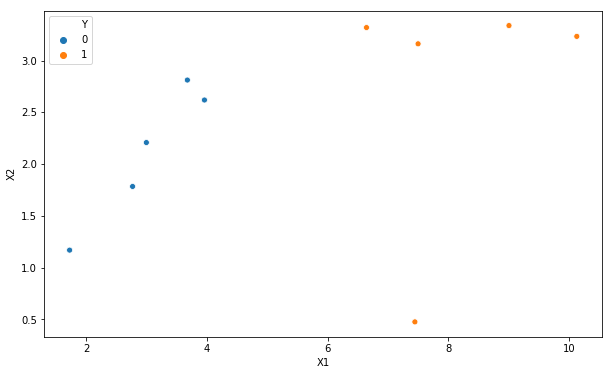

In [17]:
plt.rcParams['figure.figsize']=(10,6)
sns.scatterplot(x = cart_df['X1'],y = cart_df['X2'],hue = cart_df['Y'])

In [112]:
cart_df.loc[1,'X1']

1.72857

In [175]:
def cart(df):
    feat_1 = df.columns[0]
    feat_2 = df.columns[1]
    target = df.columns[-1]
    def gini(feat,row,dataset = df):
        df_gini = df.copy()
        #return df_gini.loc[1,feat]

        for i in range(df_gini.count()[0]):
            if df_gini.loc[i,feat] < df_gini.loc[row,feat]:
                df_gini.loc[i,'Group'] = 0
            else:
                df_gini.loc[i,'Group'] = 1
        try:
            count_left = df_gini['Group'].value_counts()[0]
        except:
            count_left = 0
        try:
            count_right = df_gini['Group'].value_counts()[1]
        except:
            count_right = 0
        
        count_0_left = df_gini[(df_gini[target] == df_gini['Group']) & (df_gini[target] == 0)].count()[0]
        count_1_left = df_gini[(df_gini[target] != df_gini['Group']) & (df_gini[target] == 1)].count()[0]
        count_0_right = df_gini[(df_gini[target] != df_gini['Group']) & (df_gini[target] == 0)].count()[0]
        count_1_right = df_gini[(df_gini[target] == df_gini['Group']) & (df_gini[target] == 1)].count()[0]

        g_split = ((count_0_left/count_left) * (1 - count_0_left/count_left))+ \
                   ((count_0_right/count_right) * (1 - count_0_right/count_right)) + \
                   ((count_1_left/count_left) * (1 - count_1_left/count_left)) + \
                   ((count_1_right/count_right) * (1 - count_1_right/count_right)) 
        return g_split
    
    l = []
    
    for i in range(0,df.count()[0]):
        gini_split = gini(dataset = df,feat = feat_1,row = i)
        l.append((i,feat_1,df.loc[i,feat_1],gini_split))
        
    for i in range(0,df.count()[0]):
        gini_split = gini(dataset = df,feat = feat_2,row = i)
        l.append((i,feat_2,df.loc[i,feat_2],gini_split))
    l_gini = [i[-1] for i in l]
    gini_min = min(l_gini)
    l_final = list(filter(lambda x: gini_min == x[-1],l))
    
    return l_final

In [176]:
cart(cart_df)

C:\Users\ssiva\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars


[(9, 'X1', 6.64339, 0.0)]

In [174]:
knn(tit_train_norm.iloc[:,:],[1,.1,0,0,.01,1,1,0],'Survived',k = 10)

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived,sum_sqrd_diffs
0,1.0,0.268139,0.2,0.0,0.014151,1.0,0.0,1.0,0,2.068288
1,0.0,0.470032,0.2,0.0,0.139136,0.0,0.0,0.0,1,3.193599
2,1.0,0.318612,0.0,0.0,0.015469,0.0,0.0,1.0,1,3.047821
3,0.0,0.432177,0.2,0.0,0.103644,0.0,0.0,1.0,1,4.159111
4,1.0,0.432177,0.0,0.0,0.015713,1.0,0.0,1.0,0,2.110374
5,0.0,0.671924,0.0,0.0,0.101229,1.0,0.0,1.0,0,3.335420
6,1.0,0.015773,0.6,0.2,0.041136,1.0,0.0,1.0,0,2.408064
7,1.0,0.331230,0.0,0.4,0.021731,0.0,0.0,1.0,1,3.213605
8,0.5,0.167192,0.2,0.0,0.058694,0.0,0.0,0.0,1,2.296886
9,1.0,0.041009,0.2,0.2,0.032596,0.0,0.0,1.0,1,3.083990


In [268]:
new_df = pd.DataFrame(data = [[1,1,.2,0,0,1,0,1],[1,1,.2,0,0,1,0,1]])
new_df

,0,1,2,3,4,5,6,7
0,1,1,0.2,0,0,1,0,1
1,1,1,0.2,0,0,1,0,1


In [249]:
l_list_test = []
for rn in range(new_df.count()[0]):
    l_list_test.append(list(new_df.iloc[rn,:]))
l_list_test

[[1.0, 1.0, 0.2, 0.0, 0.0, 1.0, 0.0, 1.0],
 [1.0, 1.0, 0.2, 0.0, 0.0, 1.0, 0.0, 1.0]]

In [278]:
knn(tit_train_norm.iloc[:,:],new_pts_list= [[1,1,.2,0,0,1,0,1],[1,1,.2,0,0,1,0,1],[1,1,.2,0,0,1,0,1],[1,.2,0,1,1,0,1,0]],dep_col = 'Survived')

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived
0,1.0,0.268139,0.2,0.0,0.014151,1.0,0.0,1.0,0
1,0.0,0.470032,0.2,0.0,0.139136,0.0,0.0,0.0,1
2,1.0,0.318612,0.0,0.0,0.015469,0.0,0.0,1.0,1
3,0.0,0.432177,0.2,0.0,0.103644,0.0,0.0,1.0,1
4,1.0,0.432177,0.0,0.0,0.015713,1.0,0.0,1.0,0
5,0.0,0.671924,0.0,0.0,0.101229,1.0,0.0,1.0,0
6,1.0,0.015773,0.6,0.2,0.041136,1.0,0.0,1.0,0
7,1.0,0.331230,0.0,0.4,0.021731,0.0,0.0,1.0,1
8,0.5,0.167192,0.2,0.0,0.058694,0.0,0.0,0.0,1
9,1.0,0.041009,0.2,0.2,0.032596,0.0,0.0,1.0,1


In [187]:
tit_train_norm.iloc[0:3,:]

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived
0,1.0,0.268139,0.2,0.0,0.014151,1.0,0.0,1.0,0
1,0.0,0.470032,0.2,0.0,0.139136,0.0,0.0,0.0,1
2,1.0,0.318612,0.0,0.0,0.015469,0.0,0.0,1.0,1


In [76]:
# def euclid_dist(df,pt1,pt2,output_col):
#     l_elems = []
#     l_diffs = []
#     sum_sqrd_diffs = 0
#     df2 = df.drop(output_col,axis=1)
#     for col_num in range(0,len(df2.columns)):
#         sum_sqrd_diffs += (df2.iloc[pt2,col_num] - df2.iloc[pt1,col_num])**2
# #         for row_num1 in range(0,df2.count()[0]):
# #             for row_num2 in range(row_num1+1,df2.count()[0]):
# #                 sum_sqrd_diffs += (df2.iloc[row_num2,col_num] - df2.iloc[row_num1,col_num])**2
# #                 #l_elems.append((df2.iloc[row_num2,col_num] - df2.iloc[row_num1,col_num])**2)
        
#             #for col_num2 in range(col_num1,len(df2.columns)):
#             #    l_elems.append((df2.iloc[row,col_num2] - df2.iloc[row,col_num1])**2)
#     return sum_sqrd_diffs #sum(l_elems)
#         #for num in range(0,len(df.drop('output_col')),)

# Logistic Regression (Titanic Dataset)

In [9]:
titanic_test = pd.read_csv(r'C:\Users\ssiva\Downloads\Python-Data-Science-and-Machine-Learning-Bootcamp\Python-Data-Science-and-Machine-Learning-Bootcamp\Machine Learning Sections\Logistic-Regression\titanic_test.csv')

In [10]:
titanic_train = pd.read_csv(r'C:\Users\ssiva\Downloads\Python-Data-Science-and-Machine-Learning-Bootcamp\Python-Data-Science-and-Machine-Learning-Bootcamp\Machine Learning Sections\Logistic-Regression\titanic_train.csv')

In [11]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
titanic_train.drop(['PassengerId','Name','Ticket'],axis = 1,inplace = True)

In [13]:
titanic_train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [14]:
titanic_train.drop(['Cabin'],axis = 1,inplace = True)
titanic_test.drop(['Cabin'],axis = 1,inplace = True)

In [15]:
titanic_train.dropna(inplace = True)
titanic_test.dropna(inplace = True)

In [16]:
titanic_train.count()[0]

712

In [17]:
titanic_train.head(6)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
6,0,1,male,54.0,0,0,51.8625,S


In [19]:
tit_train_cnvrtd = convert_cat(titanic_train,['Sex','Embarked'],output_col = 'Survived')
tit_train_cnvrtd.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived
0,3,22.0,1,0,7.2500,1,0,1,0
1,1,38.0,1,0,71.2833,0,0,0,1
2,3,26.0,0,0,7.9250,0,0,1,1
3,1,35.0,1,0,53.1000,0,0,1,1
4,3,35.0,0,0,8.0500,1,0,1,0


In [20]:
# tit_test_cnvrtd = convert_cat(titanic_test,['Sex','Embarked'],output_var = 'Survived')
# tit_test_cnvrtd.head()
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [23]:
tit_train = split_df(tit_train_cnvrtd)

In [24]:
tit_train.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived
0,3,22.0,1,0,7.2500,1,0,1,0
1,1,38.0,1,0,71.2833,0,0,0,1
2,3,26.0,0,0,7.9250,0,0,1,1
3,1,35.0,1,0,53.1000,0,0,1,1
4,3,35.0,0,0,8.0500,1,0,1,0


In [25]:
tit_test = split_df(tit_train_cnvrtd,df_to_return='test')
tit_test.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived
498,3,51.0,0,0,7.0542,1,0,1,0
499,1,32.0,0,0,30.5000,1,0,0,1
500,3,9.0,3,2,27.9000,0,0,1,0
501,2,28.0,0,0,13.0000,0,0,1,1
502,3,32.0,0,0,7.9250,1,0,1,0


In [26]:
tit_train_norm = normalize(tit_train)
tit_test_norm = normalize(tit_test)

In [27]:
tit_train_norm.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived
0,1.0,0.268139,0.2,0.0,0.014151,1.0,0.0,1.0,0.0
1,0.0,0.470032,0.2,0.0,0.139136,0.0,0.0,0.0,1.0
2,1.0,0.318612,0.0,0.0,0.015469,0.0,0.0,1.0,1.0
3,0.0,0.432177,0.2,0.0,0.103644,0.0,0.0,1.0,1.0
4,1.0,0.432177,0.0,0.0,0.015713,1.0,0.0,1.0,0.0


In [29]:
coeffs_list = stoch_grad_desc(tit_train_norm,output_col = 'Survived',alpha = 0.5, epoch = 100,algo='log')

In [30]:
coeffs_list

[5.297875928276206,
 -3.787762457158588,
 -3.9152703370653277,
 -1.4904885285807647,
 0.6840651195676772,
 -2.5720391672249105,
 -2.901730290347972,
 0.6929381373404175,
 0.0914470367436114]

In [32]:
tit_train_pred = make_predictions(tit_train_norm,coeff_list = coeffs_list,algo = 'log',output_col = 'Survived')

In [33]:
tit_test_pred = make_predictions(tit_test_norm,coeff_list = coeffs_list,algo = 'log',output_col = 'Survived')

In [34]:
check_accuracy(tit_train_pred,algo = 'log')

0.7931726907630586

In [35]:
check_accuracy(tit_test_pred,algo = 'log')

0.813084112149529